# Introduction


The character recognition problem is implemented and compared with two algorithms / techniques with lots of preprocessing. The packages used to accomplish this task are cv2, NumPy, mahotas for preprocessing. Scikit-learn for feature extraction and implementing SVM (support vector machines) and Keras for implementing a CNN (Convolutional Neural Net). I am attaching two jupyter notebooks for this submission one for each algorithm. Just replace the file paths to chars74k-lite dataset to train and detection images 1 and 2 to test.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mahotas
import glob
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from skimage import feature, exposure
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
fp_chars = '/Users/manohar/Desktop/chars74k-lite'
fp_detect1 = '/Users/manohar/Desktop/detection-images/detection-1.jpg'
fp_detect2 = '/Users/manohar/Desktop/detection-images/detection-2.jpg'

# Feature Engineering


After locating files with help of glob package, we read with opencv module and convert the images grayscale 3  channel to grayscale 1 channel. As first steps to preprocessing and feature extraction we try to remove noise, blurr the image to apply thresholding. we use otsu thresholding here as it working well after experimenting.


In [3]:

images = []
labels = []
for i in glob.glob(fp_chars+'/*'):
    for file in glob.glob(i+'/*.jpg'):
        #read the file in cv2
        image = cv2.imread(file)
        #convert from 3 channel to 1 channel
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #remove noise
        image = cv2.fastNlMeansDenoising(image)
        #blur the image with 5,5 window
        image = cv2.GaussianBlur(image,(5,5),0)
        #Thresholding with otsu
        T = mahotas.thresholding.otsu(image)
        img = image.copy()
        img[img>T]=255
        img[img<255]=0
        img=cv2.bitwise_not(img) 
        #add image the list
        images.append(img)
        #add label of the image 
        labels.append(file[39])
        

In [4]:
img.shape


(20, 20)

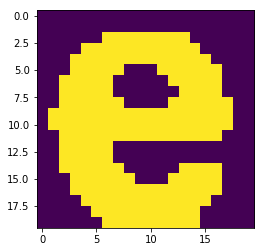

'e'

In [5]:
plt.imshow(images[6000])
plt.show()
labels[6000]



hog(histogram of oriented gradients) is performed and experimented with 16 and 9 bins. 16 bin-hog actually gave us better results in SVM. HOG descriptor works based on orientation of the edge directions of the image which are took by gradients. First an X-gradient is computed with convolution of mask [-1,0,1] and Y-gradient mask is computed with transpose of [-1,0,1], then calculate the gradient magnitude and direction of each cell. return the histogram of bins.



In [11]:
bin_n = 9
def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)  # hist is a 64 bit vector
    return hist

In [12]:
hog(images[100])

array([  2966.77545166,   6995.51794434,  17126.38128662,   1442.49786377,
         3652.76159668,   1442.49786377,   2846.38079834,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,   3652.76159668,   6608.28283691,  16133.5512085 ,
            0.        ,      0.        ,   2846.38079834,   2248.87866211,
        24107.10241699,   1442.49780273,      0.        ,    360.62445068,
         5906.38079834,   2248.87866211,    806.38079834,      0.        ,
            0.        ,   2846.38079834,   1442.49786377,   3652.76159668,
         1081.87341309,   9180.        ,  13991.03588867,   3893.55090332])

HOG is applied to each image and list of histograms of images are stored in data. labels of images are converted to integers for training. The data is then split to train and test datasets.

In [13]:
data =[hog(img) for img in images]
uniq_labels = list(set(labels))
labels_int = [uniq_labels.index(i) for i in labels]

In [14]:
x_train ,x_test, y_train ,y_test = train_test_split(data, labels_int, shuffle=True, random_state=22)

c) I thought of implementing SIFT for 

# Character Classification


Yes, the character classification itself is a multiclass problem with 26 classes. So, initial thoughts were to use SVM(supervised) or K-means(unsupervised) and CNN(supervised). But stuck with SVM and CNN as they were giving better results. These models are chosen because they are well for classification problems and proven to work very well.



Model-1 SVM (Support Vector Machines)

working of SVM
Support vector machines catogorizes the examples by creating an optimal hyperplane by training the model with labeled data(supervised). The optical hyperplane is created leaving the maximum margin distance from all the classes. The algorithm itself takes in the training data labeled with different classes and the model is trained so that an optimal hyperplane is achieved to distinguish the classes. This model is then used to predict the classes of the test dataset for evaluation.

Model-2 CNN (Convolutional Neural Network)

working of CNN
A neural network is a combination of layers of neurons where each neuron takes in an input does an operation and passes through an activation function before going to next neuron in next layer as input. The basic CNN depends on the best convolutional kernel for each layer and backpropagation to achieve optimal weights. As the images are array of multidimentional numbers. The CNN adjusts the convolutional kernels to idetentify a specific feature in each layer more information about convonets can be found here - http://cs231n.github.io/convolutional-networks/ . For our conv net I used relu as our activation function in the inner(hidden) layer and softmax in the output layer with 26 neurons for 26 classes. total number of layers - 6 with 4 hidden and the fifth layer is a dense fully connected layer with 1024 neurons.

I chose these models because I know that these models work well on high dimensional data like images and from experience of previous implementations on similair datasets like CIFAR10 etc.

## SVM

In [29]:
#HOG bins = 16
model = SVC(C=10,gamma=0.001,kernel='poly')
svm_model = model.fit(x_train,y_train)

In [31]:
#test
y_pred = svm_model.predict(x_test)

In [32]:
accuracy_score(y_test,y_pred)

0.77052868391451068

In [15]:
#hog bins = 9
model = SVC(kernel='poly')
svm_model = model.fit(x_train,y_train)
y_pred = svm_model.predict(x_test)
accuracy_score(y_test,y_pred)

0.76940382452193479

In [40]:
def detection(fp, clf, size=(20,20), model=model):
        image = cv2.imread(fp)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # blur the image, find edges, and then find contours along
        # the edged regions
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        edged = cv2.Canny(blurred, 30, 150)
        (_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # sort the contours by their x-axis position, ensuring
        # that we read the characters from left to right
        cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in cnts], key = lambda x: x[1])

        # loop over the contours
        for (c, _) in cnts:
            # compute the bounding box for the rectangle
            (x, y, w, h) = cv2.boundingRect(c)

            # if the width is at least 5 pixels and the height
            # is at least 10 pixels, the contour is likely a digit
            if w >= 5 and h >= 10:
                # crop the ROI and then threshold the grayscale
                roi = image[y:y + h, x:x + w]
                roi = cv2.resize(roi, size)
                roi = cv2.fastNlMeansDenoising(roi)
                thresh = roi.copy()
                T = mahotas.thresholding.otsu(image)
                thresh[thresh > T] = 255
                thresh[thresh < 255] = 0
                thresh = cv2.bitwise_not(thresh)
                if clf=='svm':
                    hist = hog(thresh)
                    char =  uniq_labels[model.predict([hist])[0]]
                elif clf=='cnn':
                    thresh = thresh/255.
                    thresh = thresh.reshape(1, size[0], size[1], 1)
                    char = model.predict_classes(thresh)
                    char = uniq_labels[int(char)]
                #print("I think that character is: {}".format(char))

                # draw a rectangle around the char, the show what the character is
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
                cv2.putText(image, str(char), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
        plt.figure(figsize=(18,24))
        plt.imshow(image)
        plt.show()
        

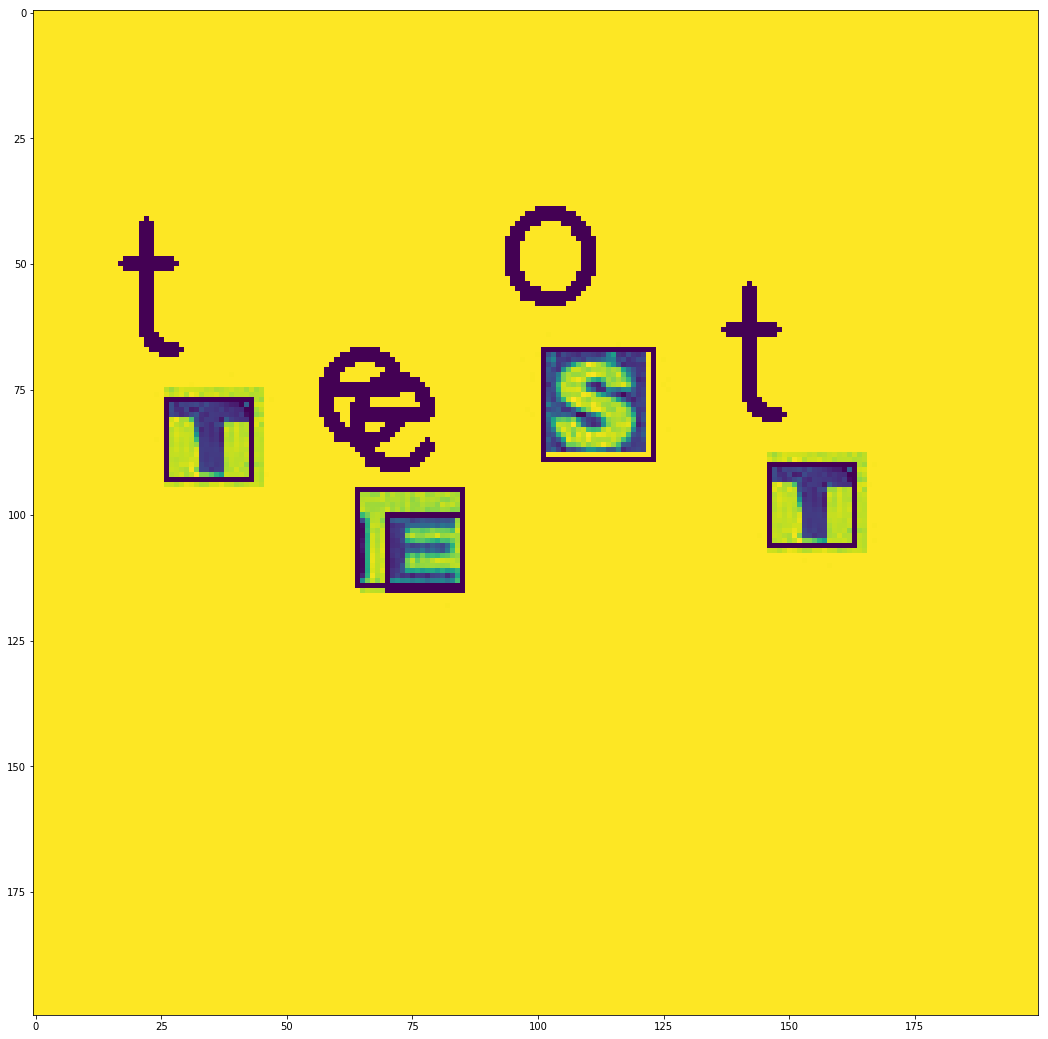

In [41]:
detection(fp_detect1, clf='svm', model=svm_model)

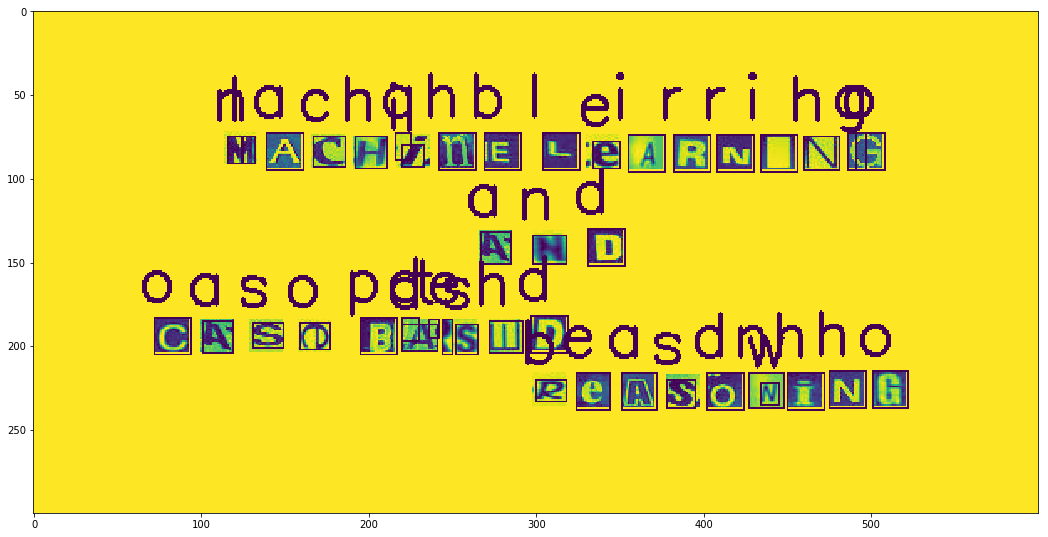

In [39]:
detection(fp_detect2, clf='svm', model=svm_model)